In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from IPython.display import clear_output
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, auc
from torch.optim import Adam
from torchsummary import summary
from torchtext.legacy import datasets, data
from torchtext.vocab import GloVe, FastText
from tqdm import tqdm, trange
from utils import *

In [2]:
torch.cuda.set_device(0)
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
DEVICE

device(type='cuda')

In [3]:
TEXT = data.Field(lower=True, include_lengths=True, batch_first=True)
LABEL = data.Field(sequential=False)

train, test = datasets.IMDB.splits(TEXT, LABEL)

In [4]:
TEXT.build_vocab(train, vectors=GloVe('6B', dim=300))
LABEL.build_vocab(train)

In [5]:
BATCH_SIZE = 32
train_iter, test_iter = data.BucketIterator.splits(
    (train, test), batch_size=BATCH_SIZE, device=DEVICE)

In [6]:
val_data = []
for i, batch in enumerate(test_iter):
    val_data.append(batch)
    if i == 30:
        break

In [15]:
class AttentiveModel(nn.Module):
    def __init__(self, vocab_size=len(TEXT.vocab), emb_size=300, hidden_size=256, n_heads=1):
        super().__init__()
        self.name = 'LSTM neural network with self-attention'
        self.eos_idx = 1

        self.embeddings = nn.Embedding(num_embeddings=vocab_size, embedding_dim=emb_size)
        self.lstm = nn.LSTM(input_size=emb_size, hidden_size=hidden_size, batch_first=True, bidirectional=True)
        self.attention = nn.MultiheadAttention(2 * hidden_size, n_heads)

        self.linear_head = nn.Sequential(
            nn.Linear(2 * hidden_size, 256),
            nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.Linear(128, 2)
        )

    def forward(self, input):
        text_embeddings = self.embeddings(input[0]) # [batch_size, sentence_len, emb_size]
        mask = self._compute_mask(input)

        attn_mask = mask.unsqueeze(1)
        attn_mask = torch.bitwise_not(torch.tile(attn_mask, (1, mask.shape[1], 1)))

        lstm_output, _ = self.lstm(text_embeddings) # [batch_size, sentence_len,  2 * hid_size]
        lstm_output = lstm_output.swapaxes(0, 1) # [sentence_len, batch_size, 2 * hid_size]

        attention_output, attention_output_weights = self.attention(lstm_output, lstm_output, lstm_output, attn_mask=attn_mask)
        self.attention_output_weights = attention_output_weights # [batch_size, sentence_len, 2 * hid_size]

        attention_output = attention_output.swapaxes(0, 1) # [batch_size, sentence_len, 2 * hid_size]


        mask = mask.unsqueeze(2)
        output = torch.mean(attention_output * mask, dim=1)

        return self.linear_head(output) # [batch_size, 2]

    def predict(self, input):
        return torch.argmax(self.forward(input), dim=1)

    def get_attention_weights(self, input):
        self.forward(input)
        return self.attention_output_weights

    def _compute_mask(self, input):
        return F.pad(torch.cumsum(input[0] == self.eos_idx, dim=-1)[..., :-1] < 1, pad=(1, 0), value=True)

In [16]:
model = AttentiveModel().to(DEVICE)
optim = Adam(model.parameters(), lr=1e-4)

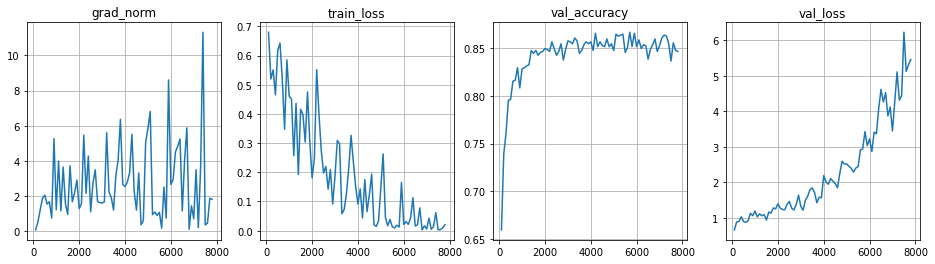

Mean loss=0.020


100%|██████████| 10/10 [21:54<00:00, 131.49s/it]


In [17]:
train_model(model, optim, train_iter, val_data, n_epochs=10)

Scores for LSTM neural network with self-attention:
Accuracy: 0.99824
Precision: 0.9978417266187051
Recall: 0.99864
Area under ROC-curve: 0.9999


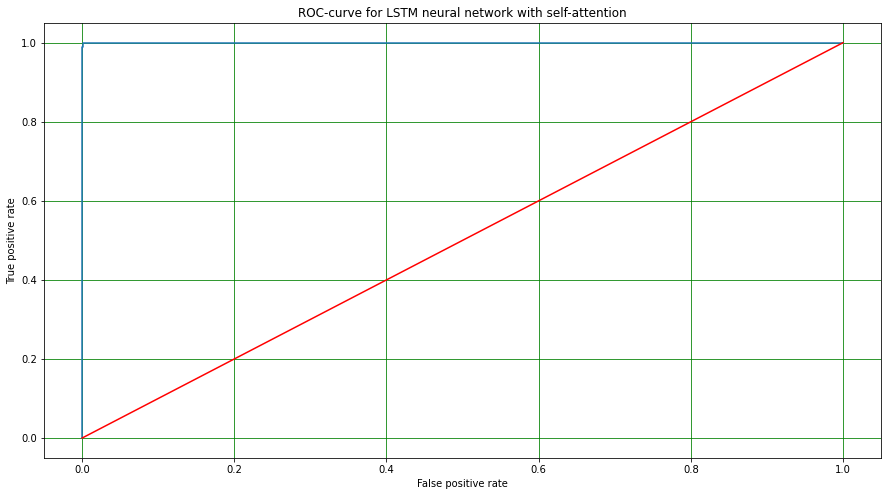

In [18]:
get_scores(model, train_iter, print_scores=True, from_iter=True)
plot_roc_curve(model, train_iter)

Scores for LSTM neural network with self-attention:
Accuracy: 0.845
Precision: 0.8980156898938625
Recall: 0.7784
Area under ROC-curve: 0.9308


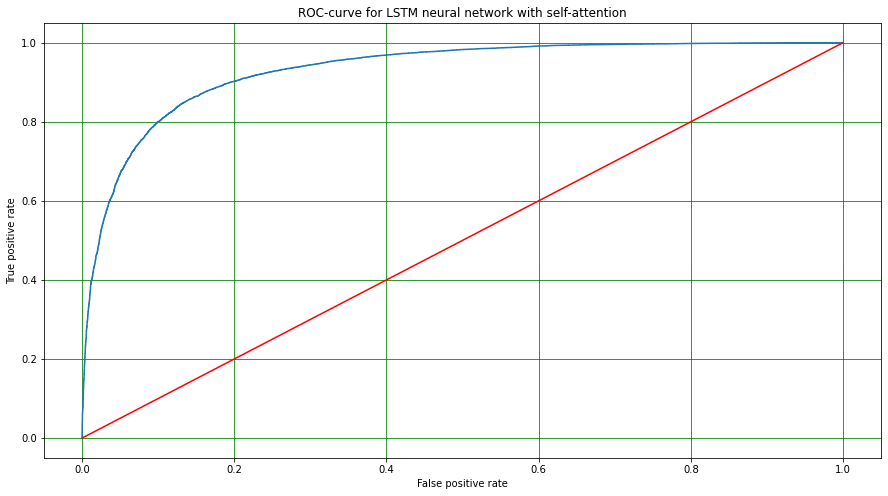

In [19]:
get_scores(model, test_iter, print_scores=True, from_iter=True)
plot_roc_curve(model, test_iter)

Черновой вариант: скор выше до уменьшения learning_rate, добавления маски для attention.

In [ ]:
model = AttentiveModel().to(DEVICE)
optim = Adam(model.parameters(), lr=1e-3)

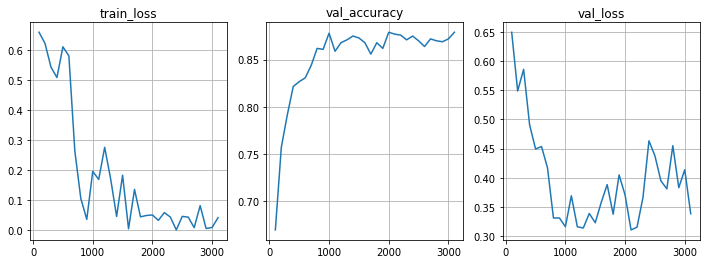

Mean loss=0.029



100%|██████████| 4/4 [10:48<00:00, 162.11s/it]


In [ ]:
train_model(model, optim, train_iter, val_data, n_epochs=4)

Scores for LSTM neural network with self-attention:
Accuracy: 0.99864
Precision: 0.9991191543882126
Recall: 0.99816
Area under ROC-curve: 1.0000


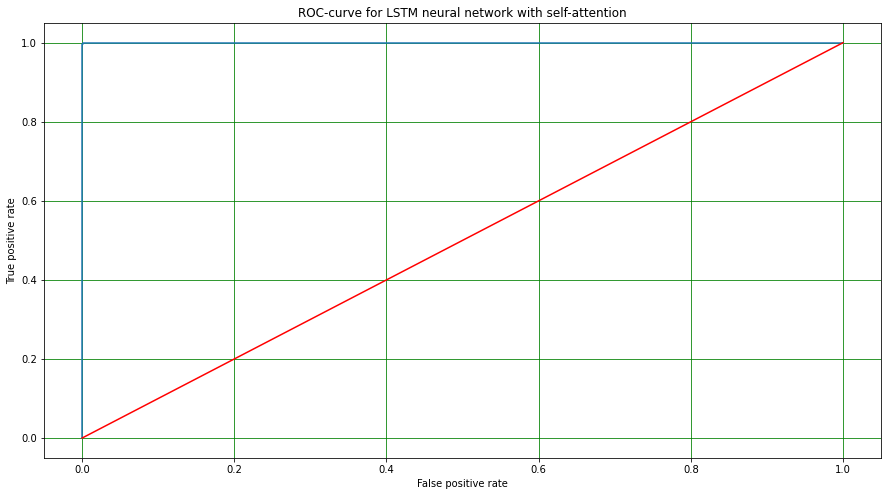

In [ ]:
get_scores(model, train_iter, print_scores=True, from_iter=True)
plot_roc_curve(model, train_iter)

Scores for LSTM neural network with self-attention:
Accuracy: 0.87204
Precision: 0.865979381443299
Recall: 0.88032
Area under ROC-curve: 0.9396


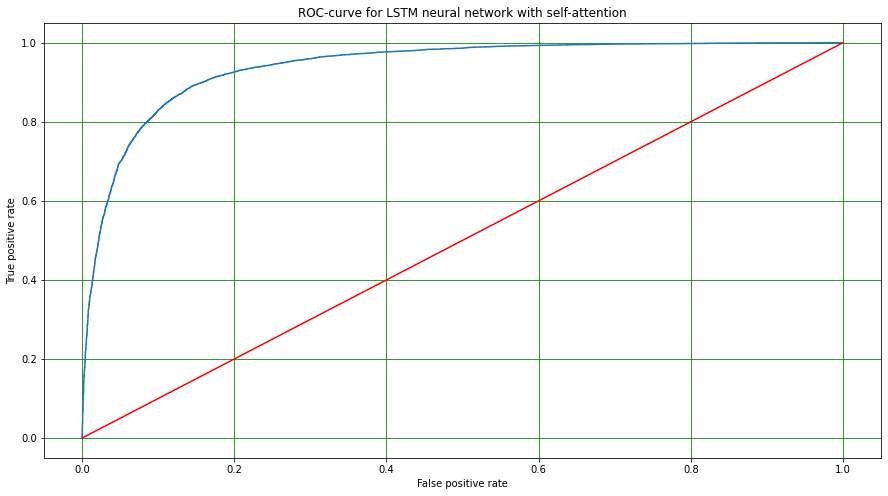

In [ ]:
get_scores(model, test_iter, print_scores=True, from_iter=True)
plot_roc_curve(model, test_iter)